In [1]:
!pip freeze > requirements.txt

## Result (2023-02)
    1. 레이블별 해상도 체크: 모두 1920x1080이 아님 
    2. 너무 작은 width, height를 가지는 데이터들은 제외됨
    3. 관심영역의 크기가 편차가 심함, 256, 384, 512로 먼저 생성
        - 이후 그래픽카드 가용 메모리에 따라 조정
        - 카메라 구도에 따른 (1)입력 이미지 해상도 축소와 늘리는 방법, (2)제로 패딩 시도 해봐야 함
        - 카메라 해상도가 다를 때 사용하는 기술들의 논문 찾기 필요
        - 이미지 전처리 방법 적용 방안 (논문 참고)
    4. 제외된 이미지들이 있으며, 해당 이미지들은 매우 가까이서 찍은 사진들로 따로 추출이 필요할 수 있음
    5. PCA, TSNE

## processing (2023-03-13)
1. 레이블별 해상도 이슈 (해상도는 모두 다르기야 하겠지만, 카메라의 구도 문제?)
2. 너무 작은 데이터, 너무 큰 데이터의 분포 확인
3. 전처리의 방법
- resize (보간법 4, 8), transforms.resize
- ratio + zero_padding (보간법 4, 8)
- 보간법 cubic으로 진행
4. pca, tsne를 통해 데이터의 모인 정도를 확인

In [2]:
# default
from pprint import pprint
import natsort
import os, sys
import json
import pickle as pkl
from tqdm import notebook

# data structure
import numpy as np
from PIL import Image

# visualize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
import cv2

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

In [4]:
TRAIN = 0
VALID = 1
data_type = ["train", "valid"]
data_label = ["A1", "A2", "A3", "A4", "A5", "A6"]

project_path = "E:/Tukorea/Capstone/"

In [5]:
csv_data_list = list()

for label in data_label:
    csv_path = f"{project_path}{label}.csv"
    csv_data = pd.read_csv(csv_path, encoding="CP949")
    
    # preprocessing
    exist_index = csv_data.loc[csv_data["exist"] == "Y"].index
    csv_data = csv_data.loc[exist_index].copy()
    csv_data.drop(["Unnamed: 0", "exist", "diagnosis", "src_path", "label_path", "type", "fileformat", "copyrighter"], axis=1, inplace=True)
    
    csv_data_list.append(csv_data)

csv_data 0
(array([2.800e+01, 5.790e+02, 1.111e+03, 9.650e+02, 8.100e+02, 6.070e+02,
       5.620e+02, 5.060e+02, 4.030e+02, 3.720e+02, 3.560e+02, 3.030e+02,
       2.780e+02, 2.300e+02, 2.100e+02, 1.870e+02, 1.390e+02, 1.250e+02,
       1.200e+02, 9.100e+01, 1.030e+02, 4.800e+01, 7.000e+01, 6.300e+01,
       6.000e+01, 4.400e+01, 3.400e+01, 3.000e+01, 3.900e+01, 2.200e+01,
       2.400e+01, 1.400e+01, 2.300e+01, 2.500e+01, 1.900e+01, 1.000e+01,
       1.200e+01, 1.300e+01, 9.000e+00, 7.000e+00, 7.000e+00, 8.000e+00,
       6.000e+00, 3.000e+00, 6.000e+00, 3.000e+00, 2.000e+00, 6.000e+00,
       3.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 4.000e+00, 1.000e+00,
       4.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
       2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
       0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00,

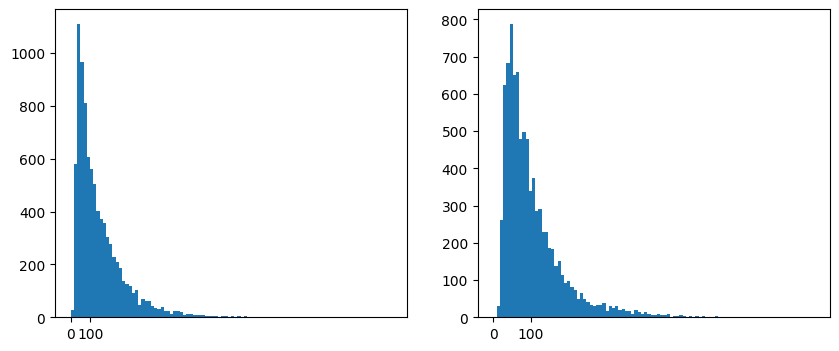

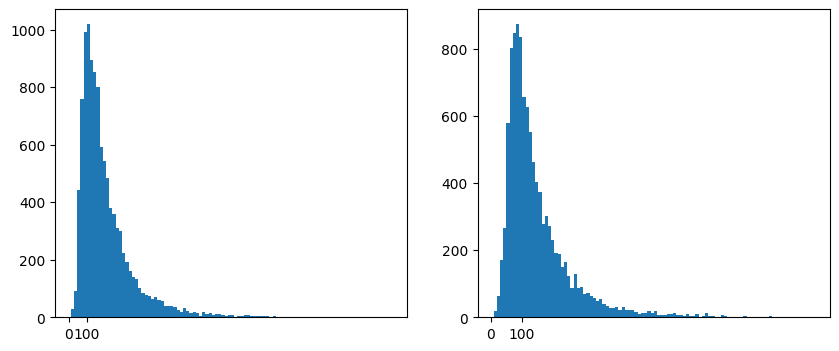

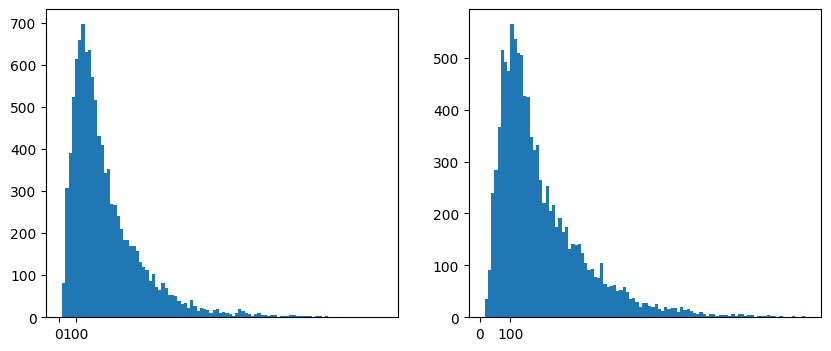

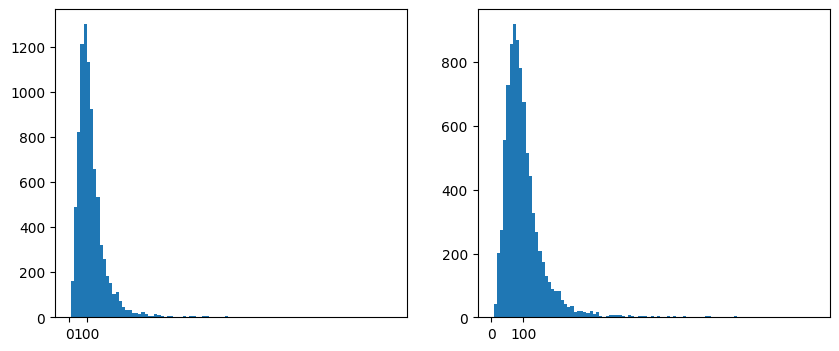

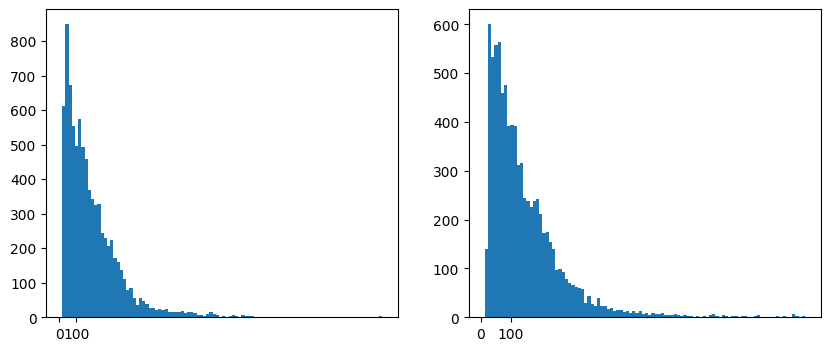

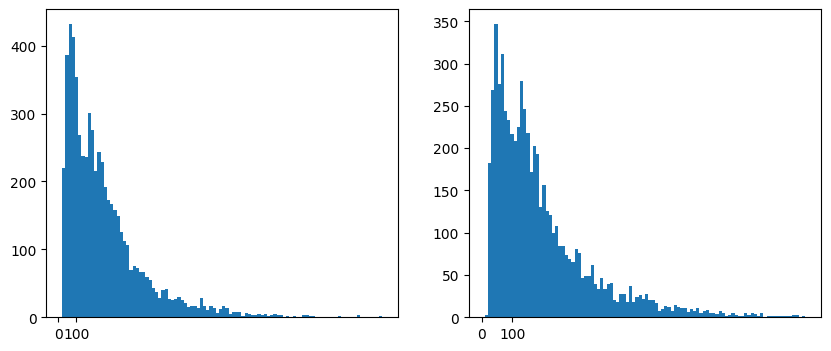

In [66]:
for i, csv_data in enumerate(csv_data_list):
    print(f"csv_data {i}")
    width = csv_data["width"]
    height = csv_data["height"]

    # canvas, plot graph
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].set_xticks([0, 2000, 100])
    ax[1].set_xticks([0, 1200, 100])
    print(ax[0].hist(width, bins=100, label="width"))
    print(ax[1].hist(height, bins=100, label="height"))

    width_desc = width.describe()
    height_desc = height.describe()

    csv_data_dict = dict()
    for index in width_desc.index:
        csv_data_dict[index] = (width_desc[index], height_desc[index])
    pprint(csv_data_dict)
    print()

(array([220., 387., 432., 413., 354., 268., 237., 236., 301., 276., 216.,
       243., 228., 192., 172., 167., 158., 149., 125., 112., 107.,  70.,
        75.,  72.,  66.,  67.,  59.,  55.,  43.,  37.,  29.,  40.,  42.,
        27.,  26.,  27.,  30.,  25.,  21.,  15.,  17.,  16.,  13.,  29.,
        16.,  11.,  16.,  13.,   7.,  12.,  16.,  13.,   5.,   8.,   8.,
         8.,   2.,   6.,   5.,   4.,   3.,   5.,   3.,   5.,   2.,   4.,
         5.,   3.,   3.,   1.,   2.,   1.,   2.,   0.,   0.,   3.,   3.,
         2.,   2.,   0.,   0.,   1.,   1.,   1.,   1.,   0.,   2.,   0.,
         0.,   0.,   1.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,   0.,
         2.]), array([  21.  ,   38.93,   56.86,   74.79,   92.72,  110.65,  128.58,
        146.51,  164.44,  182.37,  200.3 ,  218.23,  236.16,  254.09,
        272.02,  289.95,  307.88,  325.81,  343.74,  361.67,  379.6 ,
        397.53,  415.46,  433.39,  451.32,  469.25,  487.18,  505.11,
        523.04,  540.97,  558.9 ,  576.83,  594

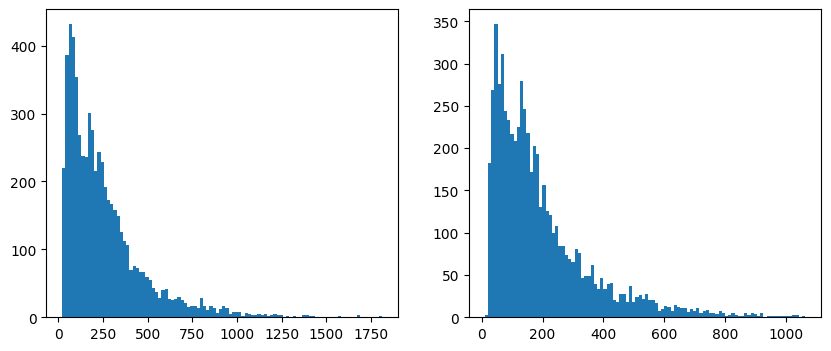

In [63]:
width = csv_data["width"]
height = csv_data["height"]

# canvas, plot graph
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
print(ax[0].hist(width, bins=100, label="width"))
print(ax[1].hist(height, bins=100, label="height"))